This notebook provides an overview of you can use CEBRA:
- in different modes
- across different sessions/animals
- across different modalities.

These examples can be found on the demos they provide on their webpage. They are directly retrieved from  some of those notebooks. This notebook highlights what we think are the important pieces to get started using CEBRA.

NB:
- make sure the environment has  'cebra[datasets,demos]'  installed, if not you can install them with this line:
    ! pip install --pre 'cebra[datasets,demos]' 
- Access to a GPU is recommended for this notebook if a runtime below 45 minutes is desired (or you can leave out the second last cell to significantly reduce the run time if you don't have access to a GPU).



In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.cebra_utils as cp


from matplotlib.collections import LineCollection
import pandas as pd

Let's load the data that we'll be using first.

In [2]:
# these are neural recordings from the hippocampus of different rats combined with behavioural data -
# (the position + direction of the rats along a linear track)

hippocampus_a = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_b = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_c = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_g = cebra.datasets.init('rat-hippocampus-single-gatsby')

In [3]:
# neural + behaviour data from one rat
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')
type(hippocampus_pos)

cebra.registry.add_helper_functions.<locals>.parametrize.<locals>._create_class.<locals>._ParametrizedClass

In [4]:
# take a quick look at how our data looks
print('neural data shape:',hippocampus_pos.neural.shape)
print('behaviour data shape:',hippocampus_pos.continuous_index.shape)

neural data shape: torch.Size([10178, 120])
behaviour data shape: torch.Size([10178, 3])


In [5]:
# use GPU if it's there
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"


# A. Different Modes

CEBRA has 3 different modes: CEBRA-Time(Discovery Mode), CEBRA-Behaviour (Hypothesis Mode) and CEBRA-Hybrid that's a cross between the two.

## 1. CEBRA Time

We start by building the CEBRA-Time model. This type of model is only trained on neural data and produces an embedding based on the existing temporal structure of the input data i.e. points that are close together in time in the input will also be close together on the embedding produced.

In [6]:
max_iterations = 2000

In [7]:
# build the model
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

The important parameter that we'll explore here is the **'conditional'** parameter.

NB: Model architecture and distance are also parameters that require some care when changing but we'll look at that in a different notebook.

In [8]:
# Train the model on neural data only
cebra_time_model.fit(hippocampus_pos.neural)

pos: -0.8211 neg:  6.3786 total:  5.5575 temperature:  1.1200: 100%|██████████| 2000/2000 [00:16<00:00, 123.61it/s]


CEBRA(batch_size=512, conditional='time', max_iterations=2000,
      model_architecture='offset10-model', output_dimension=3, temperature=1.12,
      time_offsets=10, verbose=True)

In [9]:
# Then transform the input to produce the embedding
cebra_time_embedding = cebra_time_model.transform(hippocampus_pos.neural)

## 2. CEBRA Behaviour

Now let's combine neural activity and behavioural labels to construct the manifold embeddings.

In [10]:
# build the model
cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Here, we change the conditional to be 'time-delta' to allow the algorithm to use the behavioural labels in the construction of the latent space. Note that the label can be continuous(e.g. position in space) or discrete (e.g. binary choice). The example below shows a continuous label being used.

In [11]:
# train the model using both neural data and behavioural label(s)
cebra_behavior_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())

pos: -0.8839 neg:  6.4156 total:  5.5317 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 150.35it/s]


CEBRA(batch_size=512, conditional='time_delta', max_iterations=2000,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

In [12]:
# then transform the input to produce an embedding - 
cebra_behavior_embedding = cebra_behavior_model.transform(hippocampus_pos.neural)

note that we only transform the neural data (the behavioural labels are only used in training -- for both the CEBRA-Behaviour and CEBRA-hybrid).

## 3. CEBRA - Hybrid

In [13]:
# build the model
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

Notice that this model parameters look very similar to the CEBRA-Behaviour ones. The only difference is that here we set the 'hybrid' parameter to 'True'.

In [14]:
# train the model using both neural data and the behavioural label(s)
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())

behavior_pos: -0.8841 behavior_neg:  6.4209 behavior_total:  5.5369 time_pos: -0.9112 time_neg:  6.4209 time_total:  5.5097: 100%|██████████| 2000/2000 [00:23<00:00, 85.68it/s]


CEBRA(batch_size=512, conditional='time_delta', hybrid=True,
      max_iterations=2000, model_architecture='offset10-model',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

In [15]:
# transform the input to obtain the embedding
cebra_hybrid_embedding = cebra_hybrid_model.transform(hippocampus_pos.neural)

Now let's visualise the embeddings

In [16]:
# group the behaviour labels into either right/left direction
right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

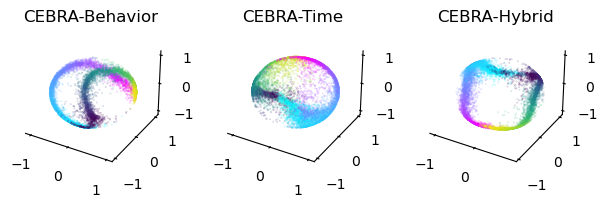

In [17]:
%matplotlib inline
# then plot the embeddings: making sure to show right vs left direction of motion using different colour maps
# the gradient of the colour map shows the position on the linear track

fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_behavior_embedding[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Behavior', cmap=cmap)
    ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_time_embedding[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Time', cmap=cmap)
    ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_hybrid_embedding[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Hybrid', cmap=cmap)

plt.show()

# B. Using CEBRA across sessions/animals

We will use CEBRA-Behaviour for this, and the data will be from rats performing the same task as before: running back and forth on a linear track (recordings from the hippocampus).

In [18]:
# Load the data first
names = ["achilles", "buddy", "cicero", "gatsby"]
datas = [hippocampus_a.neural.numpy(), hippocampus_b.neural.numpy(), hippocampus_c.neural.numpy(), hippocampus_g.neural.numpy()]
labels = [hippocampus_a.continuous_index.numpy(), hippocampus_b.continuous_index.numpy(), hippocampus_c.continuous_index.numpy(), hippocampus_g.continuous_index.numpy()]

### Single-session training

Here we train each model only on one set of data. But, we 'align' the datasets to the first one, i.e. we make sure if they had different sizes or number of features* (confirm).

In [19]:
# single session
embeddings = dict()

# Single session training
for name, X, y in zip(names, datas, labels):
    # Fit one CEBRA model per session (i.e., per rat)
    print(f"Fitting CEBRA for {name}")
    cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    cebra_model.fit(X, y)
    embeddings[name] = cebra_model.transform(X)


# Align the single session embeddings to the first rat
alignment = cebra.data.helper.OrthogonalProcrustesAlignment()
first_rat = list(embeddings.keys())[0]

for j, rat_name in enumerate(list(embeddings.keys())[1:]):
    embeddings[f"{rat_name}"] = alignment.fit_transform(
        embeddings[first_rat], embeddings[rat_name], labels[0], labels[j+1])


# Save embeddings in current folder
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)



Fitting CEBRA for achilles


pos: -0.8748 neg:  6.4226 total:  5.5477 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 149.53it/s]


Fitting CEBRA for buddy


pos: -0.6631 neg:  6.4550 total:  5.7918 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 149.39it/s]


Fitting CEBRA for cicero


pos: -0.5484 neg:  6.4821 total:  5.9337 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 145.99it/s]


Fitting CEBRA for gatsby


pos: -0.7324 neg:  6.4496 total:  5.7172 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 150.32it/s]


### Multisession training
Here, we train one model on all the sessions and then transform the individual datasets to get individual embeddings for the different animals. 

In [20]:
multi_embeddings = dict()

# Multisession training
multi_cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=max_iterations,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

# Provide a list of data, i.e. datas = [data_a, data_b, ...]
multi_cebra_model.fit(datas, labels)

# Transform each session with the right model, by providing the corresponding session ID
for i, (name, X) in enumerate(zip(names, datas)):
    multi_embeddings[name] = multi_cebra_model.transform(X, session_id=i)

# Save embeddings in current folder
with open('multi_embeddings.pkl', 'wb') as f:
    pickle.dump(multi_embeddings, f)

pos: -0.6732 neg:  7.8045 total:  7.1313 temperature:  1.0000: 100%|██████████| 2000/2000 [00:56<00:00, 35.60it/s]


### Compare embeddings

Now we compare the single-session and multi-sessions embeddings.

In [21]:
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)
with open('multi_embeddings.pkl', 'rb') as f:
    multi_embeddings = pickle.load(f)

In [22]:
# they made a custom function to plot the embeddings using the right/left labels they made
def plot_hippocampus(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = label[:,1] == 1
    l_ind = label[:,2] == 1

    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'

    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [r_ind,idx1],
               embedding [r_ind,idx2],
               embedding [r_ind,idx3],
               c=r_c,
               cmap=r_cmap, s=0.05, alpha=0.75)
    l=ax.scatter(embedding [l_ind,idx1],
               embedding [l_ind,idx2],
               embedding [l_ind,idx3],
               c=l_c,
               cmap=l_cmap, s=0.05, alpha=0.75)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax

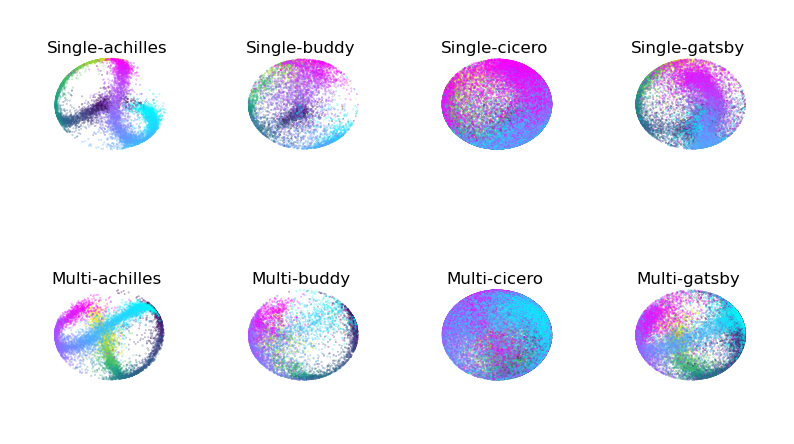

In [23]:
%matplotlib inline

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs = [ax1, ax2, ax3, ax4]

ax5 = plt.subplot(245, projection='3d')
ax6 = plt.subplot(246, projection='3d')
ax7 = plt.subplot(247, projection='3d')
ax8 = plt.subplot(248, projection='3d')
axs_multi = [ax5, ax6, ax7, ax8]

for name, label, ax, ax_multi in zip(names, labels, axs, axs_multi):
    ax = plot_hippocampus(ax, embeddings[name], label)
    ax.set_title(f'Single-{name}', y=1, pad=-20)
    ax.axis('off')
    ax_multi = plot_hippocampus(ax_multi, multi_embeddings[name], label)
    ax_multi.set_title(f'Multi-{name}', y=1, pad=-20)
    ax_multi.axis('off')


plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.show()

You can verify that these embeddings are indeed consistent by running the 'cebra.sklearn.metrics.consistency_score' function and plotting the consistency scores as shown in the demo notebook on ' Training models across animals'.

# C. Using CEBRA across modalities (Bonus)

Here, we show a brief example of how you can combine NP and Ca imaging datasets to train a model and then produce consistent embeddings for the individual datasets. For a more detailed overview, visit the CEBRA website and check out the notebook 'Decoding movie features from (V1) visual cortex'.

### Load data

In [25]:
cortex = 'VISp'
seed=333
num_neurons = 800

ca_train = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-train-10-{seed}')
np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')

ca_test = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-test-10-{seed}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')
joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')

In [26]:
# helper functions
def multi_session_solver(data_loader, **kwargs):
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    for dataset in data_loader.dataset.iter_sessions():
        dataset.to(kwargs['device'])

    model = torch.nn.ModuleList([
        cebra.models.init(m, dataset.input_dimension,
                          kwargs['num_hidden_units'], kwargs['output_dimension'], norm)
        for dataset, m in zip(data_loader.dataset.iter_sessions(), kwargs['model_architecture'])
    ]).to(kwargs['device'])

    for m in model:
        m.to(kwargs['device'])
    for n, dataset in enumerate(data_loader.dataset.iter_sessions()):
        dataset.configure_for(model[n])
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.MultiSessionSolver(model=model,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           tqdm_on=kwargs['verbose'])


@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

def _compute_emissions_multi(solver, dataset):

    return {
        i :
            get_emissions(model, session)
            for i, (model, session) in enumerate(zip(solver.model, dataset.iter_sessions()))
    }

In [27]:
train_steps = 10000

In [28]:
# create a loader to properly load the combined dataset
joint_loader = cebra.data.ContinuousMultiSessionDataLoader(joint_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset=1)

In [29]:
cebra_joint = multi_session_solver(data_loader = joint_loader, model_architecture = ['offset1-model', 'resample1-model'],
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

In [30]:
# NB: THIS CELL TAKES LONG TO RUN >45 Min without a GPU
cebra_joint.fit(joint_loader)
cebra_joint_embs = _compute_emissions_multi(cebra_joint, joint_train)

pos: -0.9987 neg:  6.9727 total:  5.9740 temperature:  1.0000: 100%|██████████| 10000/10000 [12:19<00:00, 13.53it/s]


(-0.20893637612462043,
 0.1726774252951145,
 -0.1702765017747879,
 0.14960865080356597)

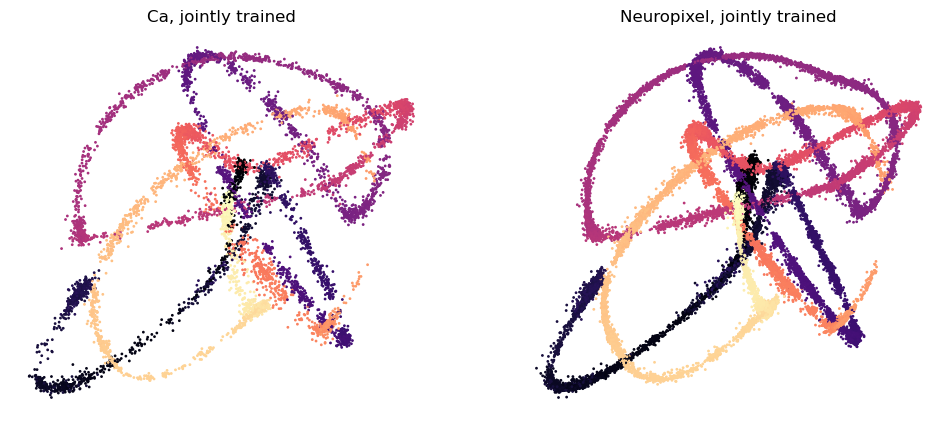

In [31]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Ca, jointly trained')
ax1.scatter(cebra_joint_embs[0][:,0], cebra_joint_embs[0][:,1], cmap = 'magma', c = np.tile(np.arange(900),9), s=1)
ax1.axis('off')

ax2 = plt.subplot(122)
ax2.set_title('Neuropixel, jointly trained')
ax2.scatter(cebra_joint_embs[1][:,0], cebra_joint_embs[1][:,1], cmap = 'magma', c = np.tile(np.repeat(np.arange(900),4),9), s=1)
ax2.axis('off')

In this example, they trained the the CEBRA model on combined data from NP and CA imaging recordings and then they used that trained model to construct individual embeddings for the NP data and CA imaging data.